In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Деревья решений в задачах классификации

In [2]:
np.random.seed(67)
points = np.random.uniform(size=(20, 2), low=-1, high=1)
positive = points[np.logical_xor(points[:, 0] >= 0, points[:, 1] >= 0)]
negative = points[np.logical_xor(points[:, 0] >= 0, points[:, 1] < 0)]
train_data = np.vstack([positive, negative])
train_labels = np.hstack([np.ones(positive.shape[0]), np.zeros(negative.shape[0])])

Рассмотрим задачу бинарной классификации. Обучающая выборка хранится в переменных `(train_data, train_labels)`.

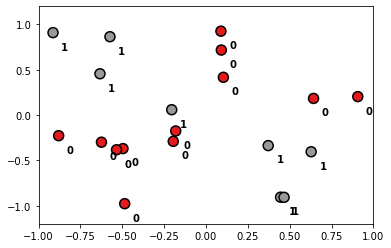

In [3]:
text_params = {'ha': 'center', 
               'va': 'top', 
               'family': 'sans-serif',
               'fontweight': 'bold'}
plt.scatter(train_data[:, 0], train_data[:, 1], 
            c=train_labels, s=100, cmap='Set1', edgecolors='black', linewidth=1.5)
for (i, j), l in zip(train_data, train_labels):
    plt.text(i + 0.07, j - 0.1, f'{int(l)}', **text_params)
plt.xlim(-1, 1)
plt.ylim(-1.2, 1.2)
plt.show()

**Задание 1.** Выберите предикаты, по которым проводить разбиение. Постройте дерево решений для данной задачи. Какой глубины будет оптимальное дерево?

In [4]:
left = train_labels[train_data[:, 0] < 0]
right = train_labels[train_data[:, 0] > 0]
train_left_data = train_data[train_data[:, 0] < 0]
train_right_data = train_data[train_data[:, 0] > 0]
right_0 = right[train_right_data[:, 1] > 0]
right_1 = right[train_right_data[:, 1] < 0]
left_0 = left[train_left_data[:, 1] < 0]
left_1 = left[train_left_data[:, 1] > 0]

In [5]:
right_0, right_1, left_0, left_1

(array([0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1.]))

**Задание 2.** В деревьях классификации часто используют энтропийный критерий и критерий Джини. Построим решающее дерево с помощью энтропийного критерия. Какой будет начальная энтропия?

$$S_0=-p log_2 p-(1-p)log_2(1-p)$$

In [6]:
def entropy(p):
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p) if 0 < p < 1 else 0
def gini(p):
    return 2 * p * (1-p)

In [7]:
entropy(train_labels.mean())

0.9709505944546686

**Задание 3.** Попробуйте перебрать все возможные разбиения из $x_1\in[-1,1]$, $x_2\in[-1,1]$. Какое правило предлагает поместить в корень дерева энтропийный критерий?

In [8]:
t = np.arange(-1, 1.05, 0.05)

In [9]:
def IG(v, U0, U1, which='entropy'):
    if which == 'entropy':
        inf = entropy
    elif which =='gini':
        inf = gini
    N, N1, N2 = list(map(len, [v, U0, U1]))
    if N1 == 0 or N2 == 0:
        return 0
    else:
        S0, S1, S2 = list(map(inf, [np.mean(v), np.mean(U0), np.mean(U1)]))
        return S0 - N1 * S1 / N - N2 * S2 / N

In [10]:
result = {'v': 0, 'IG': -10e6}

In [11]:
for x1 in t:
    U0 = train_labels[train_data[:, 0] < x1]
    U1 = train_labels[train_data[:, 0] >= x1]
    vc = IG(train_labels, U0, U1)
    if vc > result['IG']:
        result['v'] = x1
        result['IG'] = vc
        x = 'x1'

for x2 in t:
    U0 = train_labels[train_data[:, 1] < x2]
    U1 = train_labels[train_data[:, 1] >= x2]
    vc = IG(train_labels, U0, U1)
    if vc > result['IG']:
        result['v'] = x2
        result['IG'] = vc
        x = 'x2'
result['which_x'] = x

In [12]:
result

{'v': -0.39999999999999947, 'IG': 0.0918643835351961, 'which_x': 'x2'}

**Задание 4.** Постройте дерево той же глубины, что и в задании 1, пользуясь критерием Джини. С помощью полученного дерева классифицируйте объект с признаками (-0.25, 0.5).

### step1

In [13]:
result = {'v': 0, 'IG': -10e6}

In [14]:
for x1 in t:
    U0 = train_labels[train_data[:, 0] < x1]
    U1 = train_labels[train_data[:, 0] >= x1]
    vc = IG(train_labels, U0, U1, which='gini')
    if vc > result['IG']:
        result['v'] = x1
        result['IG'] = vc
        x = 'x1'

for x2 in t:
    U0 = train_labels[train_data[:, 1] < x2]
    U1 = train_labels[train_data[:, 1] >= x2]
    vc = IG(train_labels, U0, U1, which='gini')
    if vc > result['IG']:
        result['v'] = x2
        result['IG'] = vc
        x = 'x2'
result['which_x'] = x
result

{'v': -0.39999999999999947, 'IG': 0.06124999999999997, 'which_x': 'x2'}

In [15]:
v1 = result['v'] 

In [16]:
def get_data(train_data, train_labels, d: dict):
    if d['which_x'] == 'x2':
        m = train_data[:, 1] < d['v']
    elif d['which_x'] == 'x1':
        m = train_data[:, 0] < d['v']
    left = train_data[m]
    right = train_data[np.logical_not(m)]
    left_labels = train_labels[m]
    right_labels = train_labels[np.logical_not(m)]
    return left, right, left_labels, right_labels

In [17]:
left, right, left_labels, right_labels = get_data(train_data, train_labels,result)

In [18]:
result = {'v': 0, 'IG': -10e6}
for x1 in t:
    U0 = left_labels[left[:, 0] < x1]
    U1 = left_labels[left[:, 0] >= x1]
    vc = IG(left_labels, U0, U1, which='gini')
    if vc > result['IG']:
        result['v'] = x1
        result['IG'] = vc
        x = 'x1'

for x2 in t:
    U0 = left_labels[left[:, 1] < x2]
    U1 = left_labels[left[:, 1] >= x2]
    vc = IG(left_labels, U0, U1, which='gini')
    if vc > result['IG']:
        result['v'] = x2
        result['IG'] = vc
        x = 'x2'
result['which_x'] = x
result

{'v': -0.4499999999999995, 'IG': 0.375, 'which_x': 'x1'}

In [19]:
v2 = result['v'] 

In [20]:
result = {'v': 0, 'IG': -10e6}
for x1 in t:
    U0 = right_labels[right[:, 0] < x1]
    U1 = right_labels[right[:, 0] >= x1]
    vc = IG(right_labels, U0, U1, which='gini')
    if vc > result['IG']:
        result['v'] = x1
        result['IG'] = vc
        x = 'x1'

for x2 in t:
    U0 = right_labels[right[:, 1] < x2]
    U1 = right_labels[right[:, 1] >= x2]
    vc = IG(right_labels, U0, U1, which='gini')
    if vc > result['IG']:
        result['v'] = x2
        result['IG'] = vc
        x = 'x2'
result['which_x'] = x
result

{'v': 0.4500000000000013, 'IG': 0.07514204545454545, 'which_x': 'x2'}

In [21]:
v3 = result['v']

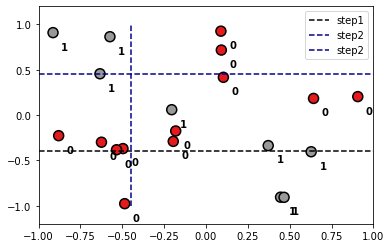

In [22]:
text_params = {'ha': 'center', 
               'va': 'top', 
               'family': 'sans-serif',
               'fontweight': 'bold'}
plt.scatter(train_data[:, 0], train_data[:, 1], 
            c=train_labels, s=100, cmap='Set1', edgecolors='black', linewidth=1.5)
for (i, j), l in zip(train_data, train_labels):
    plt.text(i + 0.07, j - 0.1, f'{int(l)}', **text_params)
plt.plot(t, np.full(t.shape, v1), '--', color='black', label='step1')
plt.plot(np.full(t.shape, v2), t , '--', color='darkblue', label='step2')
plt.plot(t, np.full(t.shape, v3), '--', color='darkblue', label='step2')
plt.xlim(-1, 1)
plt.ylim(-1.2, 1.2)
plt.legend()
plt.show()

# 2. Решение задачи регрессии

In [23]:
X = np.linspace(-2, 2, 10)
y = X ** 3

Необходимо построить дерево регрессии для решения следующей задачи:

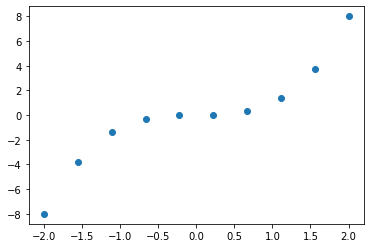

In [24]:
plt.scatter(X, y)
plt.show()

Проделаем несколько шагов в построении дерева регрессии. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. В случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

**Задание 5.** Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

**Задание 6.** Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

В алгоритме построения дерева регрессии признак и значение порога, по которым происходит разбиение выборки, выбираются по дисперсионному критерию:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

**Задание 7.** Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [25]:
def regression_var_criterion(X, y, t):
    pass

In [26]:
t = np.linspace(-1.9,1.9,200)

Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.